In [1]:
%matplotlib inline


# Performance-over-time plot
This example shows, how to use the *performance_over_time_* attribute to plot the performance
over train time.  *performance_over_time_* can contain multiple metrics within a pandas dataframe, namely:

    - ensemble_optimization_score
    - ensemble_test_score
    - single_best_optimization_score
    - single_best_test_score
    - single_best_train_score

*auto-sklearn* can automatically encode categorical columns using a label/ordinal encoder.
This example highlights how to properly set the dtype in a DataFrame for this to happen,
and showcase how to input also testing data to autosklearn.

The X_train/y_train arguments to the fit function will be used to fit the scikit-learn model,
whereas the X_test/y_test will be used to evaluate how good this scikit-learn model generalizes
to unseen data (i.e. data not in X_train/y_train). Using test data is a good mechanism to measure
if the trained model suffers from overfit, and more details can be found on [evaluating estimator
performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

In order to provide *\*_test_score* metrics, X_test and y_test must be provided to the AutoML-Model, as 
shown in this example.

There is also support to manually indicate the feature types (whether a column is categorical
or numerical) via the argument feat_types from fit(). This is important when working with
list or numpy arrays as there is no per-column dtype (further details in the example
`sphx_glr_examples_40_advanced_example_feature_types.py`).


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from smac.tae import StatusType

import autosklearn.classification

/home/peng/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading



In [3]:
# Using Australian dataset https://www.openml.org/d/40981.
# This example will use the command fetch_openml, which will
# download a properly formatted dataframe if you use as_frame=True.
# For demonstration purposes, we will download a numpy array using
# as_frame=False, and manually creating the pandas DataFrame
X, y = sklearn.datasets.fetch_openml(data_id=40981, return_X_y=True, as_frame=False)

# bool and category will be automatically encoded.
# Targets for classification are also automatically encoded
# If using fetch_openml, data is already properly encoded, below
# is an example for user reference
X = pd.DataFrame(data=X, columns=["A" + str(i) for i in range(1, 15)])
desired_boolean_columns = ["A1"]
desired_categorical_columns = ["A4", "A5", "A6", "A8", "A9", "A11", "A12"]
desired_numerical_columns = ["A2", "A3", "A7", "A10", "A13", "A14"]
for column in X.columns:
    if column in desired_boolean_columns:
        X[column] = X[column].astype("bool")
    elif column in desired_categorical_columns:
        X[column] = X[column].astype("category")
    else:
        X[column] = pd.to_numeric(X[column])

y = pd.DataFrame(y, dtype="category")

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5, random_state=3
)
print(X.dtypes)

A1         bool
A2      float64
A3      float64
A4     category
A5     category
A6     category
A7      float64
A8     category
A9     category
A10     float64
A11    category
A12    category
A13     float64
A14     float64
dtype: object


## Build and fit a classifier



In [4]:
cls = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    memory_limit=16384,
)
cls.fit(X_train, y_train, X_test, y_test)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=16384, per_run_time_limit=30,
                      time_left_for_this_task=120)

## Get the Score of the final ensemble



In [5]:
predictions = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score 0.8579710144927536


## Plot the ensemble performance
The *performance_over_time_* attribute returns a pandas dataframe, which can
be directly used for plotting



/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


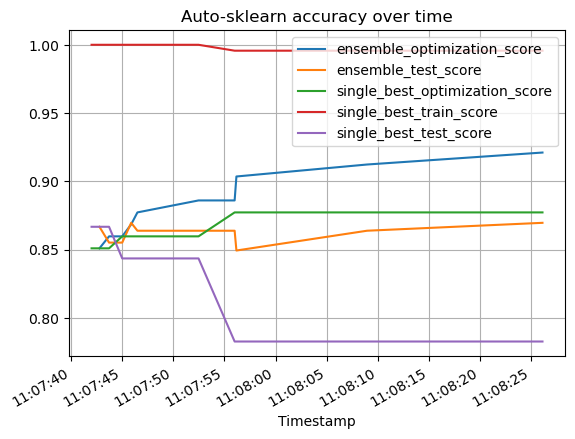

In [6]:
poT = cls.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()